In [1]:
# Importarlibrerías para tratamiento de datos
import pickle
import numpy as np
import matplotlib.pyplot as plt
from plotnine.data import mpg
import pandas as pd
import seaborn as sns
from pandas.api.types import CategoricalDtype
from plotnine import *

In [2]:
# Importar Keras y librerías adicionales
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [8]:
#Cargar DataSet 
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!ls
# Cargando data 
data = pd.read_csv('drive/My Drive/Proyecto Final INF648-0001/ObesityDataSet_raw_and_data_sinthetic.csv')
data.head()


drive  sample_data


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [10]:
#Validar data
data.isnull().sum()
#peso (kg) / [estatura (m)]2
data["IMC"]= data["Weight"]/(data["Height"]*data["Height"])


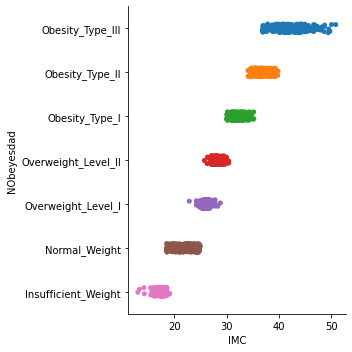

In [11]:
#Evaluando
data["NObeyesdad"].unique()
order = ['Obesity_Type_III','Obesity_Type_II','Obesity_Type_I','Overweight_Level_II','Overweight_Level_I','Normal_Weight','Insufficient_Weight']
sns.catplot(x="IMC", y="NObeyesdad", data=data,order=order, height=5)

In [246]:
X_data = data.drop("NObeyesdad",axis=1)
IMC_data = pd.DataFrame(data["IMC"])
X_data = X_data.drop("IMC",axis=1)
y_data = pd.DataFrame(data["NObeyesdad"])
print(X_data.shape)
print(y_data.shape)

(2111, 16)
(2111, 1)


In [174]:
def preprocess_dataset(dataset, save_metadata=True):
  preprocessed_dataset = dataset.copy()

  #Determinamos aquellas variables que tengan un porcentaje de registros únicos por cada variable mayor al valor de 0.7
  threshold = 0.99

  unique_percentages = dataset.nunique() / len(dataset)

  criteria = unique_percentages > threshold

  columns_to_filter = unique_percentages[criteria].keys()

  #Eliminamos las variables seleccionadas en el paso anterior
  #preprocessed_dataset.drop(columns_to_filter, axis=1, inplace=True)

  #Eliminamos los registros duplicados
  #preprocessed_dataset.drop_duplicates(keep="first", inplace=True)

  #Determinamos que variables son del tipo númerico y cuales son categóricas
  numeric_columns = list()
  categorical_columns = list()
  dictionary_of_columns_with_index_to_categorical = dict()
  dictionary_of_columns_with_categorical_to_index = dict()

  for column in preprocessed_dataset:
    #Determinamos si la variable es numérica o no
    if pd.api.types.is_numeric_dtype(preprocessed_dataset[column]):
      numeric_columns.append(column)
    else:
      #Modificamos el tipo de dato de la variable mediante "astype"
      preprocessed_dataset[column] = preprocessed_dataset[column].astype("category")

      #Verificamos si el tipo de dato de la variable fue transformado a categórico correctamente
      if not pd.api.types.is_categorical_dtype(preprocessed_dataset[column]):
        raise Exception("La columna {} no se transformó correctamente a categórica".format(column))

      dictionary_of_columns_with_index_to_categorical[column] = dict()
      dictionary_of_columns_with_categorical_to_index[column] = dict()
      
      #Indexamos los valores (categorías), sin tomar en consideración los nulos, de la variable y guardamos esa información en los diccionarios
      for index, category in enumerate(preprocessed_dataset[column].cat.categories):
        dictionary_of_columns_with_index_to_categorical[column][index] = category
        dictionary_of_columns_with_categorical_to_index[column][category] = index
      
      categorical_columns.append(column)
  
  #Reemplazamos los nulos con la mediana sólo de aquellas variables numéricas
  median_of_numeric_columns = preprocessed_dataset[numeric_columns].median()

  preprocessed_dataset[numeric_columns] = preprocessed_dataset[numeric_columns].fillna(median_of_numeric_columns)

  #Transformamos a números los valores (categorías) de las variables categóricas sin considerar los nulos
  preprocessed_dataset.replace(dictionary_of_columns_with_categorical_to_index, inplace=True)

  #Determinamos aquellas variables que tengan un porcentaje de registros nulos por cada variable mayor al valor de 0.7
  threshold = 0.99

  null_percentages = preprocessed_dataset[categorical_columns].isna().sum() / len(preprocessed_dataset)

  criteria = null_percentages > threshold

  columns_to_filter = null_percentages[criteria].keys()

  #Eliminamos las variables seleccionadas en el paso anterior
  #preprocessed_dataset.drop(columns_to_filter, axis=1, inplace=True)

  #Eliminamos los registros duplicados
  #preprocessed_dataset.drop_duplicates(keep="first", inplace=True)

  #Generamos una nueva lista de variables categóricas sin contener "Embarked" y las variables eliminadas por tener un porcentaje alto de registros nulos
  categorical_columns_filtered = categorical_columns[:]


  #
  
  if len(categorical_columns_filtered) > 0:
    #Reemplazamos los nulos con la mediana para todas las variables excepto "Embarked" y las variables eliminadas por tener un porcentaje alto de registros nulos
    median_of_categorical_columns = preprocessed_dataset[categorical_columns_filtered].median()

    preprocessed_dataset[categorical_columns_filtered] = preprocessed_dataset[categorical_columns_filtered].fillna(median_of_categorical_columns)
  
  if save_metadata:
    #Guardamos información que consideremos imporante. El formato pickle nos permite guardar objetos de python
    with open("numeric_columns.pkl", "wb") as f:
      pickle.dump(numeric_columns, f)
    
    with open("categorical_columns.pkl", "wb") as f:
      pickle.dump(categorical_columns, f)
    
    with open("dictionary_of_columns_with_index_to_categorical.pkl", "wb") as f:
      pickle.dump(dictionary_of_columns_with_index_to_categorical, f)
    
    with open("dictionary_of_columns_with_categorical_to_index.pkl", "wb") as f:
      pickle.dump(dictionary_of_columns_with_categorical_to_index, f)
  
  return preprocessed_dataset

In [177]:
#Transformamos los datos X a valores numéricos 
preprocess_X_data = preprocess_dataset(X_data)
#Guardamos nuestro dataset pre-procesado en formato pickle
preprocess_X_data.to_pickle("preprocess_data.pkl")
preprocess_X_data


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,0,21.000000,1.620000,64.000000,1,0,2.0,3.0,2,0,2.000000,0,0.000000,1.000000,3,3
1,0,21.000000,1.520000,56.000000,1,0,3.0,3.0,2,1,3.000000,1,3.000000,0.000000,2,3
2,1,23.000000,1.800000,77.000000,1,0,2.0,3.0,2,0,2.000000,0,2.000000,1.000000,1,3
3,1,27.000000,1.800000,87.000000,0,0,3.0,3.0,2,0,2.000000,0,2.000000,0.000000,1,4
4,1,22.000000,1.780000,89.800000,0,0,2.0,1.0,2,0,2.000000,0,0.000000,0.000000,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,20.976842,1.710730,131.408528,1,1,3.0,3.0,2,0,1.728139,0,1.676269,0.906247,2,3
2107,0,21.982942,1.748584,133.742943,1,1,3.0,3.0,2,0,2.005130,0,1.341390,0.599270,2,3
2108,0,22.524036,1.752206,133.689352,1,1,3.0,3.0,2,0,2.054193,0,1.414209,0.646288,2,3
2109,0,24.361936,1.739450,133.346641,1,1,3.0,3.0,2,0,2.852339,0,1.139107,0.586035,2,3


In [231]:
#Transformamos los datos Y a valores numéricos 
from sklearn.preprocessing import OrdinalEncoder
niveles = ['Insufficient_Weight','Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III' ]
enc_niveles = OrdinalEncoder(categories=[niveles])
enc_niveles.fit(y_data[["NObeyesdad"]])
preprocess_y_data=pd.DataFrame(enc_niveles.transform(y_data[["NObeyesdad"]]))
preprocess_y_data.columns = ['NObeyesdad']
preprocess_y_data.head()

,NObeyesdad
0,1.0
1,1.0
2,1.0
3,2.0
4,3.0


In [179]:
#Cargamos los datos previamente guardados
with open("numeric_columns.pkl", "rb") as f:
    numeric_columns = pickle.load(f)

with open("categorical_columns.pkl", "rb") as f:
  categorical_columns = pickle.load(f)

with open("dictionary_of_columns_with_index_to_categorical.pkl", "rb") as f:
  dictionary_of_columns_with_index_to_categorical = pickle.load(f)

with open("dictionary_of_columns_with_categorical_to_index.pkl", "rb") as f:
  dictionary_of_columns_with_categorical_to_index = pickle.load(f)

preprocessed_dataset = pd.read_pickle("preprocess_data.pkl")

In [180]:
numeric_columns


['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [181]:
categorical_columns

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS']

In [182]:
dictionary_of_columns_with_index_to_categorical.keys()

dict_keys(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS'])

In [183]:
#Vemos los índices que tienen los valores (categorías) de la columna (variable) "NObeyesdad" para verificar que los nulos no están indexados
dictionary_of_columns_with_index_to_categorical["MTRANS"]

{0: 'Automobile',
 1: 'Bike',
 2: 'Motorbike',
 3: 'Public_Transportation',
 4: 'Walking'}

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

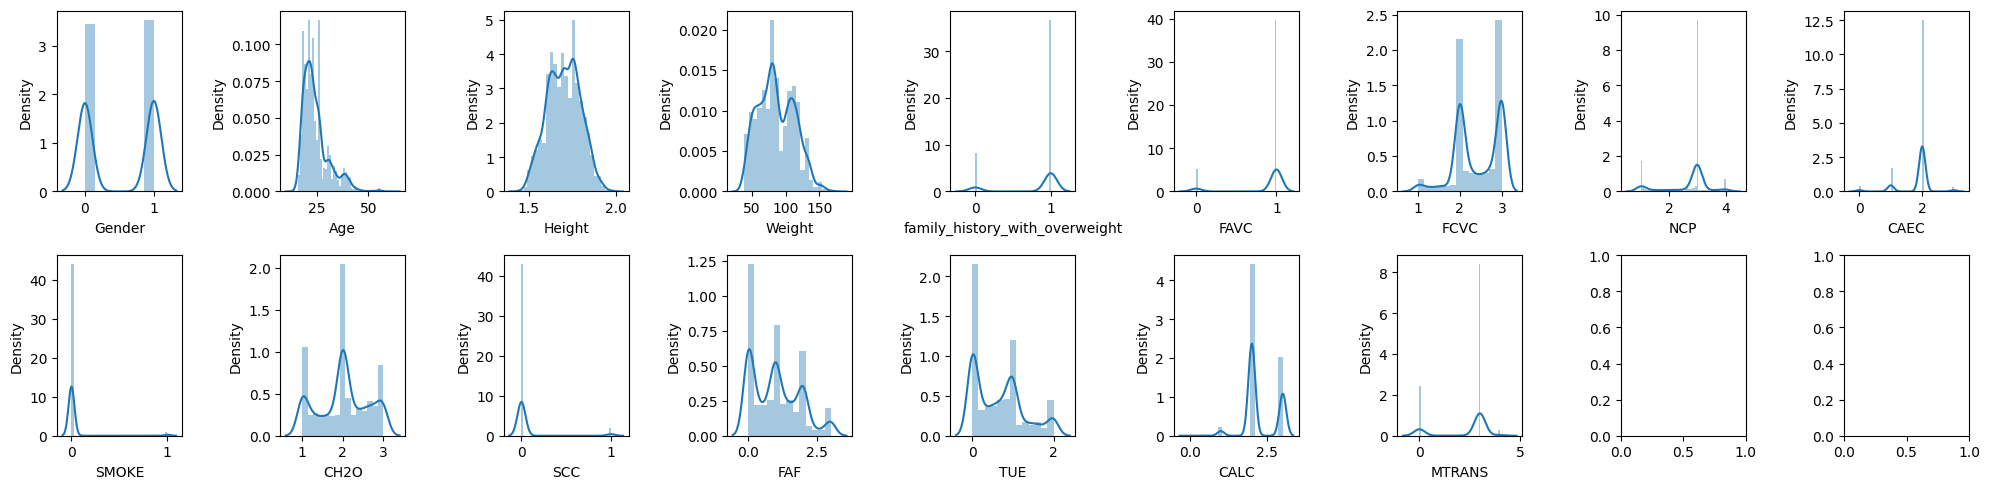

In [184]:
width = 20
height = 5

plt.style.use("default")

figure, axes = plt.subplots(nrows=2, ncols=9, figsize=(width, height))

for column, axe in zip(preprocess_X_data, axes.flatten()):
    sns.distplot(preprocess_X_data[column], ax=axe)
    
plt.tight_layout()

In [242]:
from sklearn.model_selection import train_test_split
X = preprocess_X_data.drop("Height",axis=1)
X = X.drop("Weight",axis=1)
y = preprocess_y_data

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=21)

In [186]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train_scaled = sc_X.fit_transform(X_train)

In [190]:
# encode class values as integers
from keras.utils import np_utils
dummy_y = np_utils.to_categorical(y_train)
dummy_y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [209]:
p = 0.001
# Inicializar la RNA
classifier = Sequential()

# Añadir las capas de entrada y primera capa oculta
classifier.add(Dense(units = 20, kernel_initializer = "uniform",  
                     activation = "relu", input_dim = 14))
classifier.add(Dropout(p))

# Añadir la segunda capa oculta
classifier.add(Dense(units = 15, kernel_initializer = "uniform",  activation = "relu"))
classifier.add(Dropout(p))
# Añadir la segunda capa oculta
classifier.add(Dense(units = 30, kernel_initializer = "uniform",  activation = "relu"))
classifier.add(Dropout(p))
# Añadir la segunda capa oculta
classifier.add(Dense(units = 10, kernel_initializer = "uniform",  activation = "relu"))
classifier.add(Dropout(p))


# Añadir la capa de salida
classifier.add(Dense(units = 7, kernel_initializer = "uniform",  activation = "softmax"))

# Compilar la RNA
classifier.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])


In [210]:
# Ajustamos la RNA al Conjunto de Entrenamiento
log = classifier.fit(x_train_scaled, dummy_y,  batch_size = 10, epochs = 500)

Epoch 1/500
169/169 [==============================] - 1s 2ms/step - loss: 1.9202 - accuracy: 0.1694
Epoch 2/500
169/169 [==============================] - 0s 2ms/step - loss: 1.7372 - accuracy: 0.2873
Epoch 3/500
169/169 [==============================] - 0s 2ms/step - loss: 1.6366 - accuracy: 0.3928
Epoch 4/500
169/169 [==============================] - 0s 2ms/step - loss: 1.3898 - accuracy: 0.4425
Epoch 5/500
169/169 [==============================] - 0s 2ms/step - loss: 1.2252 - accuracy: 0.4882
Epoch 6/500
169/169 [==============================] - 0s 2ms/step - loss: 1.1695 - accuracy: 0.5320
Epoch 7/500
169/169 [==============================] - 0s 2ms/step - loss: 1.1399 - accuracy: 0.5332
Epoch 8/500
169/169 [==============================] - 0s 2ms/step - loss: 1.1023 - accuracy: 0.5545
Epoch 9/500
169/169 [==============================] - 0s 2ms/step - loss: 1.0584 - accuracy: 0.5699
Epoch 10/500
169/169 [==============================] - 0s 2ms/step - loss: 1.0267 - accura

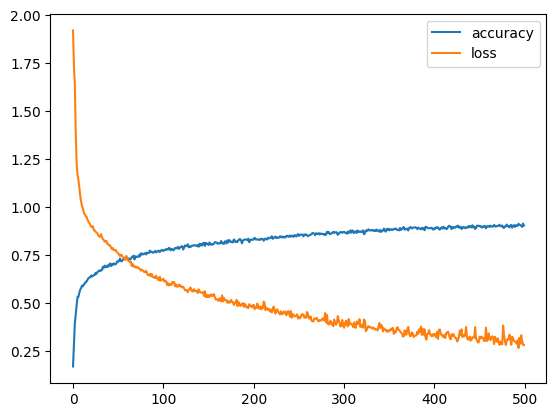

In [211]:
plt.plot(log.history['accuracy'], label='accuracy')
plt.legend();
plt.plot(log.history['loss'], label='loss')
plt.legend();

In [212]:
#calcualmos datos test 
sc_X = StandardScaler()
x_test_scaled = sc_X.fit_transform(X_test)
y_pred  = classifier.predict(x_test_scaled)

#y_test, y_pred
y_test_dummy = np_utils.to_categorical(y_test)
y_pred_dummy = np.vectorize(lambda x: int(x >= 0.5))(y_pred)
y_test_dummy

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [204]:
# calculate accuracy
#y_pred_dummy.argmax(axis=1)
#y_test_dummy.argmax(axis=1)

In [213]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
cm = confusion_matrix(y_test_dummy.argmax(axis=1), y_pred_dummy.argmax(axis=1))
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print('Model Performance')
print('Accuracy = {:0.4f}%.'.format(metrics.accuracy_score(y_test_dummy, y_pred_dummy)))
print('Recall = {:0.4f}%.'.format(np.mean(recall)))
print('Precision = {:0.4f}%.'.format(np.mean(precision)))
print('Matrix confussion')
cm

Model Performance
Accuracy = 0.7139%.
Recall = 0.6970%.
Precision = 0.7041%.
Matrix confussion


array([[49, 11,  1,  0,  4,  0,  0],
       [ 9, 25,  9,  5,  3,  1,  0],
       [10,  8, 28,  1,  5,  0,  1],
       [ 4,  3,  5, 34,  5,  4,  0],
       [ 3,  4,  2,  5, 44,  1,  0],
       [ 4,  0,  1,  7,  3, 49,  0],
       [ 0,  1,  0,  0,  0,  0, 74]])

In [278]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_scaled = sc_X.fit_transform(X)


In [376]:
#Create Clusters
X_cluster = X
X_cluster = X.drop("Gender",axis=1)
X_cluster = X_cluster.drop("Age",axis=1)
X_cluster = X_cluster.drop("family_history_with_overweight",axis=1)
x_scaled[:,1].size

2111

In [364]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
import itertools

eps = 0.95
min_samples=55
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(x_scaled)
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True
labels = clustering.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Numero de clusters: %d" % n_clusters_)
print("Numero de ruido noise points: %d" % n_noise_)
print("Porcentaje de ruido: %d" % (n_noise_/x_scaled[:,1].size))

Numero de clusters: 3
Numero de ruido noise points: 1806
Porcentaje de ruido: 0


In [377]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=2, random_state=0).fit(x_scaled)
labels = kmeans.labels_

#kmeans.cluster_centers_


In [378]:

y["NuevoNivel"]=labels
y["IMC"]=IMC_data
y.head()

,NObeyesdad,NuevoNivel,IMC
0,1.0,0,24.386526
1,1.0,0,24.238227
2,1.0,0,23.765432
3,2.0,0,26.851852
4,3.0,0,28.342381


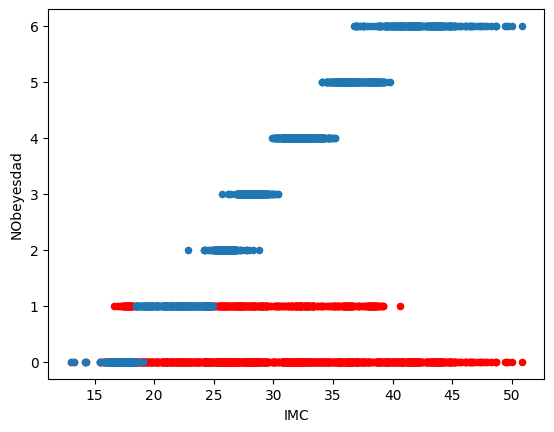

In [380]:
#sns.catplot(x="IMC", y="NObeyesdad", data=y, height=5)

import matplotlib.pyplot as plt # Impot the relevant module

fig, ax = plt.subplots() # Create the figure and axes object

y.plot(x = 'IMC', y = 'NuevoNivel', ax = ax, kind = 'scatter', color='red', secondary_y = True)
y.plot(x = 'IMC', y = 'NObeyesdad', ax = ax, kind = 'scatter') 


